# 4ab Creating a Multigrid Poisson Solver
Multigrid solvers are built on a few key observations:
  * Iterative solvers, like the Jacobi solver, correct the small scale errors of a solution faster than the large scale errors
  * The solution to the Poisson equation can be used to formulate an analogous equation for the solution of the error term
  * By using a __restriction operator__ we can solve the equation for the error term on a coarse mesh
  * By using a __prolongation operator__ we can propogate the solution for the error term from the coarse to the fine mesh
  * This can be done recursively
  * Solving on the coarse mesh is cheaper by a factor 2^ndim

In this exercise you will get the chance to build a nice recursive piece of code by yourself and create a multigrid solver. Below are only given the logical pieces, the rest you have to create.

_This exercise counts for the full week_

## Preparation:
At the bottom write a section heading, "Solution", and copy the multigrid class and the small piece of to run the solver below it. This gives you a clean reference code above, and makes it easier to see what has been modified.

## Task 1: 
Create the prolongation and restriction operators, and the central recursive algorithm (see the code below).

## Task 2:
Validate the solver. Multigrid solvers have the central property that, for a given tolerance, the number of needed multigrid cycles only depends weakly on the resolution
Compare with a simple Jacobi integrator. Notice the ```maxit```option that may have to be increased for it to converge, if you go to high resolutions.

## Task 3:
Timing: at what resolution does your multigrid solver become faster than the Jacobi solver?

## Extra open task:
The convergence properties of a multi grid solver can be be improved by not doing the full cycle up and down (V-cycle), but instead first going all the way down, then half way up, down again, and then all the way up (W-cycle). Change the solver to a W-cycle, or explore other cycle configurations (see e.g. the link at the end of the slides). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import images as im
from time import time
np.set_printoptions(linewidth=120)

### Hydro data class and initial conditions

In [2]:
class HD():
    def __init__(u,n=(32,32,32),nv=1,gamma=1.4,cs=1.,G=1.,L=1.0,d0=1.):
        # make n a 3-tuple if given as an integer
        if isinstance(n, int):
            m = (n,n,n)
        else:
            m = n
        u.n = m                             # resolution of the grid is (n[1],n[2],n[3])
        u.it= 0                             # number of updates (integer)
        u.t = 0.0                           # Time
        u.nv = nv                           # number of variables. We use nv = 8 = (density, total energy, momentum[xyz], magnetic field[xyz])
        u.ndim = 3                          # dimensionality of the experiment
        u.gamma = gamma                     # adiabatic index, currently an isothermal equation of state is not supported
        u.cs    = cs                        # sound speed only relevant if we support gamma=1.
        u.G     = G                         # Newtons constant of gravity
        u.var   = np.zeros((nv,)+m)         # conserved variables. "(nv,)+m gives a 4-tuple with (nv,n[0],n[1],n[2])"
        u.D     = u.var[0]                  # mass density pointer
        u.D[:,:,:] = d0                     # constand density
        u.coordinates(n=m,L=L)              # define coorindate system
        u.varnames=np.array(('D'))
        
    def coordinates(u,n,L=1.0):             # function to define coordinates
        # make cell centered coordinates with domain boundaries [-L:L]^ndim
        u.ds = 2.0*L / n[0]                 # cell size
        LL = 0.5*u.ds*n[0], 0.5*u.ds*n[1], 0.5*u.ds*n[2]
        u.x = np.linspace(-LL[0],LL[0],n[0], endpoint=False) + 0.5 * u.ds # cell centered coordinates
        u.y = np.linspace(-LL[1],LL[1],n[1], endpoint=False) + 0.5 * u.ds
        u.z = np.linspace(-LL[2],LL[2],n[2], endpoint=False) + 0.5 * u.ds
        u.coords = np.array(np.meshgrid(u.x,u.y,u.z,indexing='ij')) # expand to 3D grid
        u.p = np.sqrt(np.sum(u.coords[0:2]**2,axis=0)) # cylinder radius
        u.r = np.sqrt(np.sum(u.coords[0:3]**2,axis=0)) # spherical radius
        u.L = np.array(LL)                  # box size
        u.n = n                             # number of grid points

def BonnorEbert(n=32,r0=0.5,rc=0.1):
    """ Simple 1/(r+rc)^2 for r < r0 density distribution """
    u=HD(n=n)
    u.D[:,:,:] = 0.
    ii = np.where(u.r <= r0)
    u.D[ii] = 1. / (u.r[ii]+rc)**2
    return u

### Jacobi solver and computation of residual

In [3]:
#Calculating residual and residual only
def Jacobi_residual(Phi,S):
    """ calculate explicite residual for given Phi, S """
    n = Phi.shape        # grid size
    res = np.copy(S)
    for i in range(3):
        if n[i] > 1:
            res += (np.roll(Phi,+1,axis=i)+np.roll(Phi,-1,axis=i)) - 2.*Phi
    # fix boundaries
    if n[0] > 2:
        res[0,:,:] = res[-1,:,:] = 0.
    if n[1] > 2:
        res[:,0,:] = res[:,-1,:] = 0.
    if n[2] > 2:
        res[:,:,0] = res[:,:,-1] = 0.
    return res

def Jacobi(Phi,S):
    """ Jacobi iteration for multi-grid self-gravity """
    n = Phi.shape  # grid size

    const = 0.     # Prefactor for normalising dimensions (2 * ndim)
    #   phi = 1/(2ndim) (phi(i-1,j,k)+phi(i+1,j,k)+... - 4 pi G ds^2 rho)
    #   Pad Phi with zeros in each direction for boundary values (assumed to be zero) using numpy.pad
    Phi_new = np.copy(S)   # copy source
    if n[0] > 1:
        const += 2.
        PP = np.pad(Phi, ((1,1),(0,0),(0,0)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP,+1,axis=0)+np.roll(PP,-1,axis=0))[1:-1,:,:]
    if n[1] > 1:
        const += 2.
        PP = np.pad(Phi, ((0,0),(1,1),(0,0)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP,+1,axis=1)+np.roll(PP,-1,axis=1))[:,1:-1,:]
    if n[2] > 1:
        const += 2.
        PP = np.pad(Phi, ((0,0),(0,0),(1,1)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP,+1,axis=2)+np.roll(PP,-1,axis=2))[:,:,1:-1]

    Phi_new *= (1./const) # normalise

    # Return solution and residual (Phi_new - Phi = S + Laplace Phi)
    return Phi_new, Phi_new - Phi

### Iterative Jacobi solver for selfgravity

In [4]:
class poisson():
    def __init__(self, u, tolerance=1e-5,maxit=2000):
        """ Initialize a Poisson solver """
        self.n         = u.n       # Mesh size
        self.maxit     = maxit     # Maximum number of iterative steps to take
        self.tolerance = tolerance # Tolerance to satisfy for the error

    # Iterative Solver for the Poisson Problem
    def Poisson(self,u):
        S = -(4.*np.pi*u.G)*u.D*u.ds**2
        norm   = np.amax(np.abs(S))
        Phi = np.zeros(self.n)        # Start guess =0
        self.it = 0; self.error = self.tolerance
        while self.error >= self.tolerance and self.it<self.maxit:
            Phi, residual = Jacobi(Phi,S)
            self.error = np.amax(np.abs(residual) / norm)
            self.it+=1
            
        residual = Jacobi_residual(Phi,S)
                    
        return Phi, self.it, self.error, residual

### Driver for calling the Jacobi solver

Nr of iterations, error, tolerance : 5524 1.00e-05 1.0e-05
Time = 43.8 seconds, 167.0 musec/cell, 30.2 nanosec/cell/it


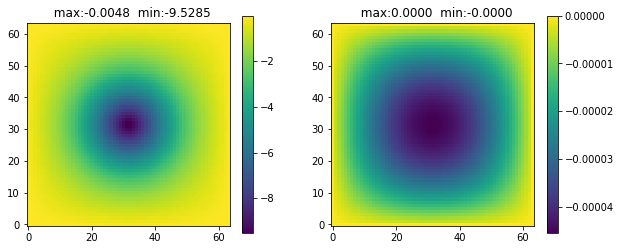

In [5]:
u = BonnorEbert(n=64,rc=0.1, r0=0.5)
P = poisson(u,maxit=8000)

start = time()
Phi, nt, err, res = P.Poisson(u)
used = time() - start
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(nt, err, P.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(used,1e6*used/ntot,1e9*used/(ntot*nt)))

# Show solution, Phi, and residual, res, side-by-side
im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

### Investigating the solution

Plot the size of the potential, $\Phi$, as a function of distance from center $r$. Notice how it strays from a perfect spherical solution because we restrict it to be zero on the boundary

/opt/conda/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


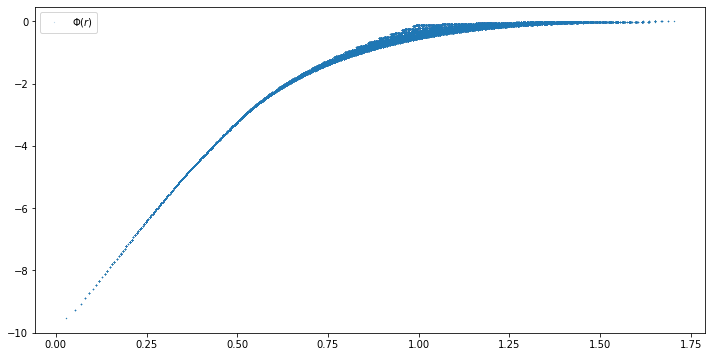

In [6]:
f = plt.figure(figsize=(12,6))
plt.plot(u.r.ravel(),Phi.ravel(),'o',markersize=0.1,label=r'$\Phi(r)$')
plt.legend();

### Multigrid Solver

Make a Multigrid solver class / object, which given a hydro object finds the solution for the potential

In [142]:
class Multigrid():
    def __init__(self,u,tolerance=1e-5,maxit=200,itsmooth=1, solvetype='V'):
        """ initialize Poisson solver class for u """
        self.itsmooth = itsmooth    # How many Jacobi iteration to take on each level
        self.maxit = maxit          # maximum number multigrid iterations. Depends on tolerance
        self.tolerance = tolerance  # tolerance to satisfy for the error
        self.setup_grids(u.n)       # generate hierarchy of grids for multigrid cycle
        self.its=[]
        self.levels=[]
        self.solvetype=solvetype
        
    def setup_grids(self,n):
        """ setup the dimensions and allocate storage for solutions on multigrid meshes """
        nn = np.array(n)                   # convert dimensions to numpy array
        nm = [];  nm.append(np.copy(nn))   # store dimension of level
        Phi = []; Phi.append(np.zeros(nn)) # array to store solution for this level
        print("MG level, n:",0, nn) # Info
        while np.any(nn % 2 == 0):         # check if any dimension still is divisible by 2
            if np.all(nn <= 2):            # reached 2x2x2 problem, stop
                break
            ii = np.where(nn % 2 == 0) # check which dimensions we can reduce
            nn[ii] = nn[ii] / 2        # reduce
            nm.append(np.copy(nn))     # store in level structure
            Phi.append(np.zeros(nn))   # array to store solution at this level
            print ("MG level, n:", len(nm)-1, nn) # info
        # Store data structure in class
        self.level = len(nm)-1         # max level (zero-indexed)
        self.n     = nm                # mesh sizes
        self.Phi   = Phi               # current solution on each level
        
    def restrict(self,f_fine, level):
        """ restrict residual to coarser level by taking every second element """
        n=level%2
        f_coarse=f_fine[n::2,n::2,n::2]
#         if self.it%500==0:
#             f_coarse.shape
        return f_coarse
    
    def prolong(self,f_coarse,level):
        """ prolong solution to finer level by copy for every second point and average for every second point """
        ns=level%2
        ns=abs(ns-1)
#         print(ns)
#         ns=0
        n = np.array(np.shape(f_coarse))
        n = tuple([2*x for x in n])
        f_fine=np.zeros(n)
        f_fine[ns::2,ns::2,ns::2]=f_coarse
        f_fine[ns::2, ns::2, :]=np.where(f_fine[ns::2, ns::2, :]==0,\
                 1/2*(np.roll(f_fine[ns::2, ns::2, :],1, axis=2)+ np.roll(f_fine[ns::2, ns::2, :],-1, axis=2)), f_fine[ns::2, ns::2, :])
        f_fine[ns::2, :, :]=np.where(f_fine[ns::2, :, :]==0,\
                 1/2*(np.roll(f_fine[ns::2, :, :],1, axis=1)+ np.roll(f_fine[ns::2, :, :],-1, axis=1)), f_fine[ns::2, :, :])
        f_fine=np.where(f_fine[:, :, :]==0,\
                 1/2*(np.roll(f_fine[:, :, :],1, axis=0)+ np.roll(f_fine[:, :, :],-1, axis=0)), f_fine[:, :, :])
#         if self.it%500==0:
#             im.imshows(np.array( [f_fine[:,:,0],f_coarse[:,:,0]]))
#             print(f_fine.shape)
        return f_fine
    
    def solver(self,S,Phi):
        """ do itsmooth Jacobi iterations """
        for i in range(self.itsmooth):
            Phi[:,:,:], residual = Jacobi(Phi,S)
        return residual
    
    # The heart of the multigrid algorithm. This function should call itself recursively.
    # As given, it just updates Phi and solves for the residual twice, which
    # corrsponds to taking two times itsmooth Jacobi iterations
    def MGcycle(self,level,source):
        residual = self.solver(source,self.Phi[level]) 
        if self.it==0:
            self.levels.append(level)# iterate solution at this level
        if (level < self.level): # if not on coarsest level, recurse
            # 1. restrict *residual* from current level to coarse level (=level+1)
            # 2. call MGcycle at coarser level (e.g. level+1)
            # 3. prolong the solution for Phi from the coarser level (=level+1) and add to solution on this level
            residual_coarse=self.restrict(residual, level)
            level+=1
            self.MGcycle(level, residual_coarse)
            self.Phi[level-1]+=self.prolong(self.Phi[level], level)
            level-=1
            if self.it==0:
                self.levels.append(level)
        residual = self.solver(source,self.Phi[level])  # iterate solution again at this level
        
    def Fcycle(self,level,source):
        residual = self.solver(source,self.Phi[level]) 
        if self.it==0:
            self.levels.append(level)# iterate solution at this level
        if (level < self.level): # if not on coarsest level, recurse
            # 1. restrict *residual* from current level to coarse level (=level+1)
            # 2. call MGcycle at coarser level (e.g. level+1)
            # 3. prolong the solution for Phi from the coarser level (=level+1) and add to solution on this level
            residual_coarse=self.restrict(residual, level)
            level+=1
            self.Fcycle(level, residual_coarse)
            self.Phi[level-1]+=self.prolong(self.Phi[level], level)
            level-=1
            residual = self.solver(source,self.Phi[level]) 
            residual_coarse=self.restrict(residual, level)
            level+=1
            self.MGcycle(level, residual_coarse)
            self.Phi[level-1]+=self.prolong(self.Phi[level], level)
            level-=1
            if self.it==0:
                self.levels.append(level)
        residual = self.solver(source,self.Phi[level])  # iterate solution again at this level
    
    def Wcycle(self,level,source):
        if (self.it==0):
            self.levels.append(level)# iterate solution at this level
        residual = self.solver(source,self.Phi[level]) 
        
        if (level < self.level): # if not on coarsest level, recurse
            source_coarse=self.restrict(residual, level)
            self.Wcycle(level+1, source_coarse)
            self.Phi[level][:,:,:] += self.prolong(self.Phi[level+1], level+1)
            residual = self.solver(source,self.Phi[level]) 
            source_coarse=self.restrict(residual, level)
            self.Wcycle(level+1, source_coarse)
            self.Phi[level][:,:,:]+=self.prolong(self.Phi[level+1], level+1)
            if (self.it==0):
                self.levels.append(level)
        residual = self.solver(source,self.Phi[level])  # iterate solution again at this level
               
    def solve(self,u):
        S = -(4.*np.pi*u.G)*u.D*u.ds**2
        norm   = np.amax(np.abs(S))                  # normalisation for residual
        self.it = 0
        self.error = self.tolerance
        # Main loop
        while self.error >= self.tolerance and self.it<self.maxit:
            if self.solvetype=='W': 
                self.Wcycle(0,S) # do a full multigrid cycle
            if self.solvetype=='F': 
                self.Fcycle(0,S) # do a full multigrid cycle
            if self.solvetype=='V':
                self.MGcycle(0,S) # do a full multigrid cycle
            self.it += 1 # inc nr of MG iterations

            res = Jacobi_residual(self.Phi[0],S)     # compute residual
            self.error = np.amax(np.abs(res) / norm) # estimate error
            self.its.append(self.it)
        return self.Phi[0], res

MG level, n: 0 [64 64 64]
MG level, n: 1 [32 32 32]
MG level, n: 2 [16 16 16]
MG level, n: 3 [8 8 8]
MG level, n: 4 [4 4 4]
MG level, n: 5 [2 2 2]
Nr of iterations, error, tolerance : 2307 1.00e-10 1.0e-10
Time = 67.8 seconds, 258.7 musec/cell, 112.1 nanosec/cell/it


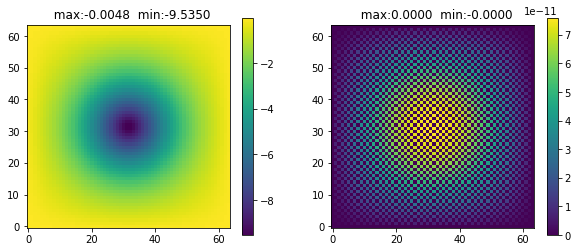

In [143]:
n=64
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = Multigrid(u,maxit=8000,itsmooth=1,tolerance=1e-10, solvetype='V')   # Setup the Multigrid solver object

start = time()              # for timing
Phi, res = M.solve(u)       # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*M.it)))

# show potential and residual
im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

In [10]:
M.levels=abs(np.array(M.levels)-M.level)

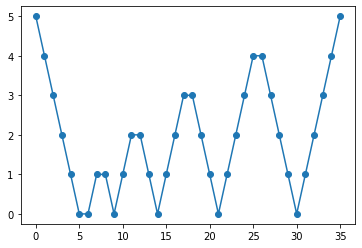

In [11]:
plt.plot(M.levels, '-o')

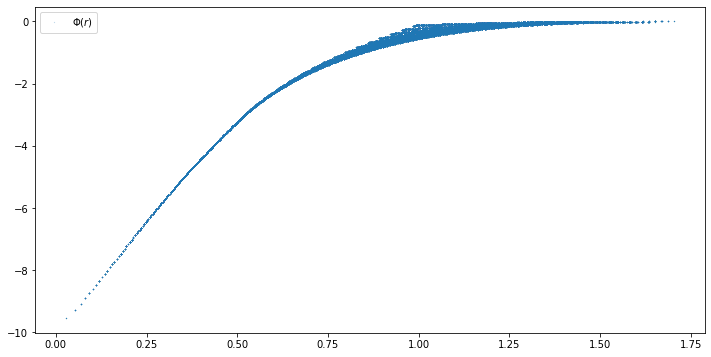

In [12]:
f = plt.figure(figsize=(12,6))
plt.plot(u.r.ravel(),Phi.ravel(),'o',markersize=0.1,label=r'$\Phi(r)$')
plt.legend();

Remember to comment on residual shape

Implementing restrict, prolong and iterative solution is the objective

## Task 1: 

See above code. Underneath there's a demonstration of the prolongation operator

In [13]:
def prolong(f_coarse,level):
        """ prolong solution to finer level by copy for every second point and average for every second point """
        if level==0:
            plt.imshow(f_coarse)
            print('Reached finest level')
        if level>0:
            n = np.array(np.shape(f_coarse))
            n = tuple([2*x for x in n])
            f_fine=np.zeros(n)
            f_fine[::2,::2,::2]=f_coarse
            f_fine[::2, ::2, :]=np.where(f_fine[::2, ::2, :]==0,\
                     1/2*(np.roll(f_fine[::2, ::2, :],1, axis=2)+ np.roll(f_fine[::2, ::2, :],-1, axis=2)), f_fine[::2, ::2, :])
            f_fine[::2, :, :]=np.where(f_fine[::2, :, :]==0,\
                     1/2*(np.roll(f_fine[::2, :, :],1, axis=1)+ np.roll(f_fine[::2, :, :],-1, axis=1)), f_fine[::2, :, :])
            f_fine=np.where(f_fine[:, :, :]==0,\
                     1/2*(np.roll(f_fine[:, :, :],1, axis=0)+ np.roll(f_fine[:, :, :],-1, axis=0)), f_fine[:, :, :])
        return f_fine

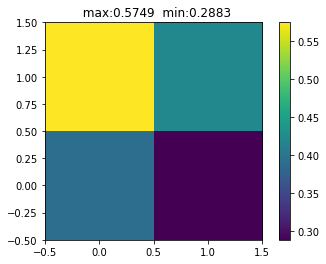

In [49]:
n=2
n1=(n,n,n)
f_fine1=np.random.random(size=n1)
im.imshow(f_fine1[:,:,0])

(512, 512, 512)


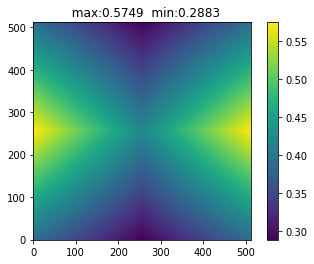

In [57]:
#just run it by ctrl+enter. Don't go above 1024 on ERDA
f_fine1=prolong(f_fine1, 2)
print(f_fine1.shape)
im.imshow(f_fine1[:,:,0])

## Task 2 and 3: 
I will keep the tolerance at 1e-5 and use the V-cycle and F-cycle as comparison

In [99]:
# Don't run this unless you have good time
# Also maybe set maxit to something much higher than 8000
time_p=[]
n_cycles_p=[]
ns=2**np.arange(2,7)
ns=ns.astype(int)
for n in ns:
    n=int(n)
    u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
    P = poisson(u,maxit=8000, tolerance=1e-5)

    start = time()
    Phi, nt, err, res = P.Poisson(u)  # for timing

    used = time() - start
    ntot = u.n[0]*u.n[1]*u.n[2]
    print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(nt, err, P.tolerance))
    print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(used,1e6*used/ntot,1e9*used/(ntot*nt)))
    time_p.append(used)
    n_cycles_p.append(nt)
    # # show potential and residual
    # im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

Nr of iterations, error, tolerance : 43 8.60e-06 1.0e-05
Time = 0.0 seconds, 637.0 musec/cell, 14814.4 nanosec/cell/it
Nr of iterations, error, tolerance : 128 9.89e-06 1.0e-05
Time = 0.1 seconds, 144.4 musec/cell, 1128.4 nanosec/cell/it
Nr of iterations, error, tolerance : 428 9.84e-06 1.0e-05
Time = 0.2 seconds, 60.8 musec/cell, 142.0 nanosec/cell/it
Nr of iterations, error, tolerance : 1499 1.00e-05 1.0e-05
Time = 1.2 seconds, 36.0 musec/cell, 24.0 nanosec/cell/it
Nr of iterations, error, tolerance : 5524 1.00e-05 1.0e-05
Time = 47.0 seconds, 179.5 musec/cell, 32.5 nanosec/cell/it


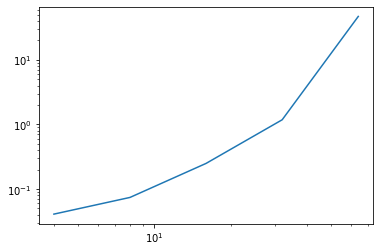

In [100]:
plt.loglog(ns, time_p)

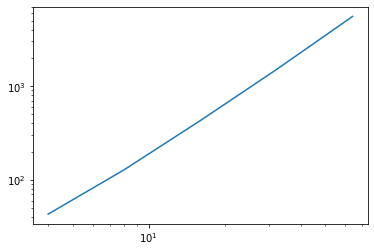

In [101]:
plt.loglog(ns, n_cycles_p)

In [102]:
time_MG_V=[]
n_cycles_V=[]
ns=2**np.arange(2,7)
ns=ns.astype(int)
for n in ns:
    n=int(n)
    u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
    M = Multigrid(u,maxit=8000,itsmooth=1,tolerance=1e-5, solvetype='V')   # Setup the Multigrid solver object

    start = time()              # for timing
    Phi, res = M.solve(u)       # call the multigrid solver
    used = time() - start       # for timing

    # print some statistics
    ntot = u.n[0]*u.n[1]*u.n[2]
    print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
    print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
        used,1e6*used/ntot,1e9*used/(ntot*M.it)))
    time_MG_V.append(used)
    n_cycles_V.append(M.it)
    # # show potential and residual
    # im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

MG level, n: 0 [4 4 4]
MG level, n: 1 [2 2 2]
Nr of iterations, error, tolerance : 21 9.14e-06 1.0e-05
Time = 0.0 seconds, 773.3 musec/cell, 36821.7 nanosec/cell/it
MG level, n: 0 [8 8 8]
MG level, n: 1 [4 4 4]
MG level, n: 2 [2 2 2]
Nr of iterations, error, tolerance : 50 9.44e-06 1.0e-05
Time = 0.2 seconds, 323.7 musec/cell, 6474.0 nanosec/cell/it
MG level, n: 0 [16 16 16]
MG level, n: 1 [8 8 8]
MG level, n: 2 [4 4 4]
MG level, n: 3 [2 2 2]
Nr of iterations, error, tolerance : 85 9.07e-06 1.0e-05
Time = 0.4 seconds, 90.8 musec/cell, 1067.8 nanosec/cell/it
MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
Nr of iterations, error, tolerance : 183 9.55e-06 1.0e-05
Time = 1.2 seconds, 37.0 musec/cell, 202.0 nanosec/cell/it
MG level, n: 0 [64 64 64]
MG level, n: 1 [32 32 32]
MG level, n: 2 [16 16 16]
MG level, n: 3 [8 8 8]
MG level, n: 4 [4 4 4]
MG level, n: 5 [2 2 2]
Nr of iterations, error, tolerance : 481 9.76e-06 1

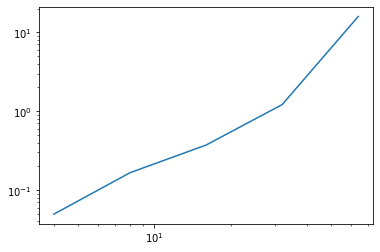

In [103]:
plt.loglog(ns, time_MG_V)

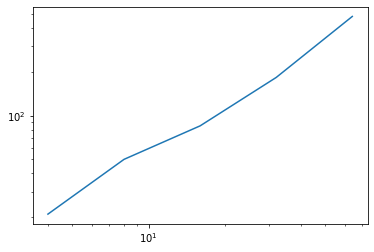

In [104]:
plt.loglog(ns, n_cycles_V)

In [107]:
time_MG_F=[]
n_cycles_F=[]
ns=2**np.arange(2,8)
ns=ns.astype(int)
for n in ns:
    n=int(n)
    u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
    M = Multigrid(u,maxit=8000,itsmooth=1,tolerance=1e-5, solvetype='F')   # Setup the Multigrid solver object

    start = time()              # for timing
    Phi, res = M.solve(u)       # call the multigrid solver
    used = time() - start       # for timing

    # print some statistics
    ntot = u.n[0]*u.n[1]*u.n[2]
    print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
    print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
        used,1e6*used/ntot,1e9*used/(ntot*M.it)))
    time_MG_F.append(used)
    n_cycles_F.append(M.it)
    # # show potential and residual
    # im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

MG level, n: 0 [4 4 4]
MG level, n: 1 [2 2 2]
Nr of iterations, error, tolerance : 14 6.05e-06 1.0e-05
Time = 0.1 seconds, 1540.9 musec/cell, 110061.3 nanosec/cell/it
MG level, n: 0 [8 8 8]
MG level, n: 1 [4 4 4]
MG level, n: 2 [2 2 2]
Nr of iterations, error, tolerance : 32 9.76e-06 1.0e-05
Time = 0.2 seconds, 472.8 musec/cell, 14775.5 nanosec/cell/it
MG level, n: 0 [16 16 16]
MG level, n: 1 [8 8 8]
MG level, n: 2 [4 4 4]
MG level, n: 3 [2 2 2]
Nr of iterations, error, tolerance : 53 8.83e-06 1.0e-05
Time = 0.6 seconds, 154.2 musec/cell, 2909.5 nanosec/cell/it
MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
Nr of iterations, error, tolerance : 59 8.66e-06 1.0e-05
Time = 1.1 seconds, 35.1 musec/cell, 594.4 nanosec/cell/it
MG level, n: 0 [64 64 64]
MG level, n: 1 [32 32 32]
MG level, n: 2 [16 16 16]
MG level, n: 3 [8 8 8]
MG level, n: 4 [4 4 4]
MG level, n: 5 [2 2 2]
Nr of iterations, error, tolerance : 117 9.94e-0

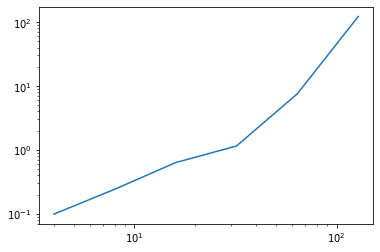

In [108]:
plt.loglog(ns, time_MG_F)

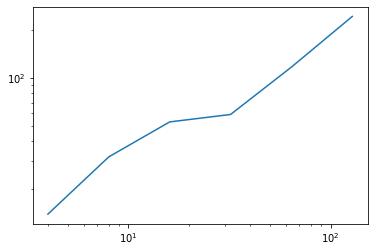

In [109]:
plt.loglog(ns, n_cycles_F)

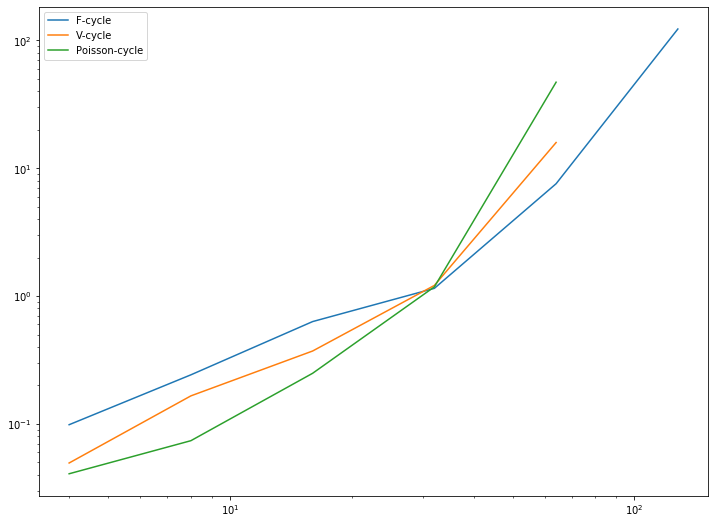

In [111]:
#Joining everything together
fig, ax=plt.subplots(figsize=(12,9))
ax.plot(ns, time_MG_F, label='F-cycle')
ax.plot(ns[:-1], time_MG_V,  label='V-cycle')
ax.plot(ns[:-1], time_p,  label='Poisson-cycle')
ax.set(yscale='log', xscale='log')
ax.legend()

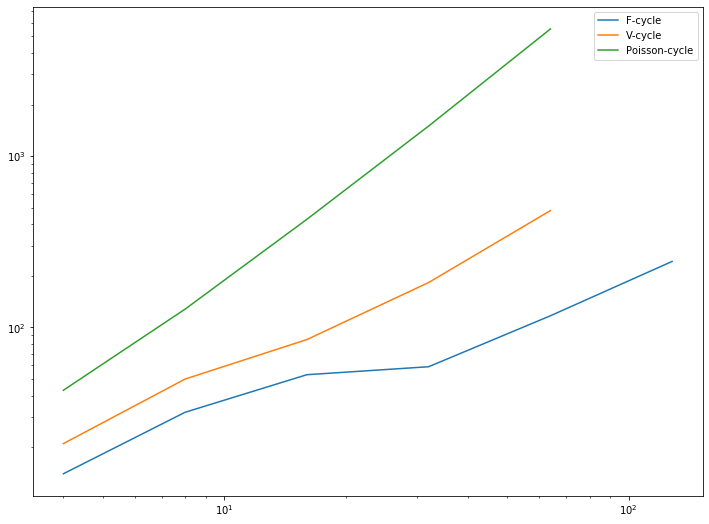

In [114]:
#Joining everything together
fig, ax=plt.subplots(figsize=(12,9))
ax.plot(ns, n_cycles_F, label='F-cycle')
ax.plot(ns[:-1], n_cycles_V, label='V-cycle')
ax.plot(ns[:-1], n_cycles_p, label='Poisson-cycle')
ax.set(yscale='log', xscale='log')
ax.legend()

All in all we see that the number of iterations scales relatively weakly with resolution, compared to the Jacobi Solver which scales pretty hard with n

The same is valid for the timing, where the MG-solver gets better at n=64 or above, while it is comparable to the Jacobi Solver down to 16, but I suspect that this is mainly due to different wall times.

For the F-cycle, we see that this becomes a bit different, and is even quicker, since doing iterations at the coarse levels doesn't "cost" as much, so we prefer to do some more iterations here

## Extra task: 

If you look above, you see that the Multigrid-solver can use V, F (Or some kind of F) and W cycles. For some reason, the W cycle seems to be not be working, but after having tried and gotten Troels in on debugging, we couldn't figure out what was wrong. Beneath I draw the resulting cycles, and then maybe you guys can see what is wrong

MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
Nr of iterations, error, tolerance : 183 9.55e-06 1.0e-05
Time = 1.3 seconds, 40.1 musec/cell, 219.3 nanosec/cell/it


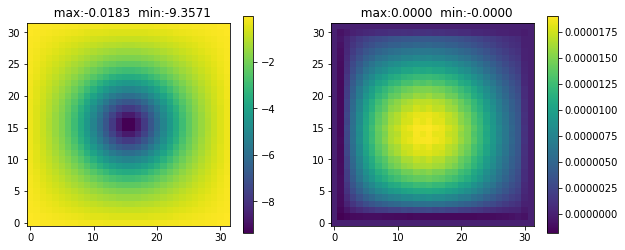

In [116]:
n=32
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = Multigrid(u,maxit=8000,itsmooth=1,tolerance=1e-5, solvetype='V')   # Setup the Multigrid solver object

start = time()              # for timing
Phi, res = M.solve(u)       # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*M.it)))

# show potential and residual
im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

In [117]:
M.levels=abs(np.array(M.levels)-M.level)

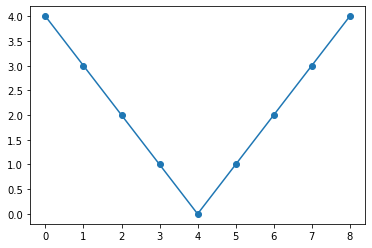

In [118]:
plt.plot(M.levels, '-o')

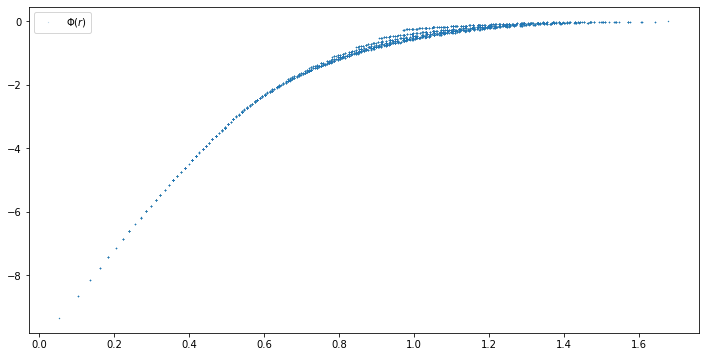

In [119]:
f = plt.figure(figsize=(12,6))
plt.plot(u.r.ravel(),Phi.ravel(),'o',markersize=0.1,label=r'$\Phi(r)$')
plt.legend();

MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
Nr of iterations, error, tolerance : 59 8.66e-06 1.0e-05
Time = 1.2 seconds, 36.2 musec/cell, 613.2 nanosec/cell/it


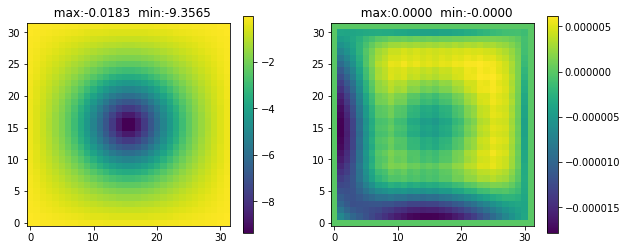

In [124]:
n=32
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = Multigrid(u,maxit=8000,itsmooth=1,tolerance=1e-5, solvetype='F')   # Setup the Multigrid solver object

start = time()              # for timing
Phi, res = M.solve(u)       # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*M.it)))

# show potential and residual
im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

In [125]:
M.levels=abs(np.array(M.levels)-M.level)

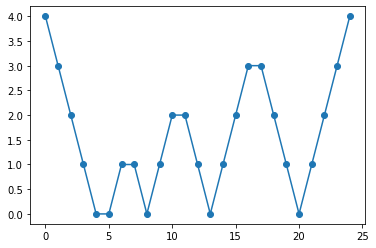

In [126]:
plt.plot(M.levels, '-o')

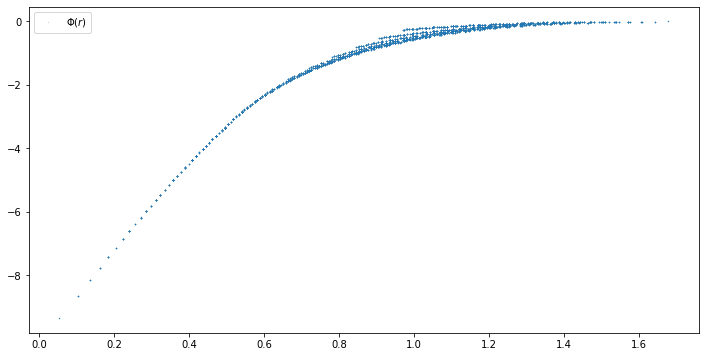

In [127]:
f = plt.figure(figsize=(12,6))
plt.plot(u.r.ravel(),Phi.ravel(),'o',markersize=0.1,label=r'$\Phi(r)$')
plt.legend();

This is a bit broken

MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
Nr of iterations, error, tolerance : 100 3.95e-04 1.0e-05
Time = 4.3 seconds, 130.9 musec/cell, 1308.7 nanosec/cell/it


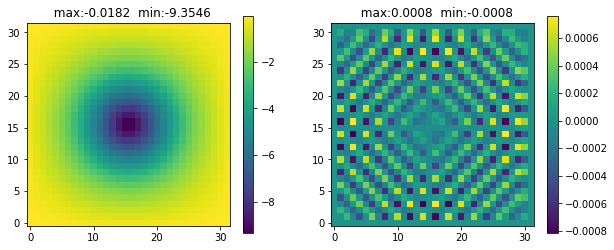

In [133]:
n=32
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = Multigrid(u,maxit=100,itsmooth=1,tolerance=1e-5, solvetype='W')   # Setup the Multigrid solver object

start = time()              # for timing
Phi, res = M.solve(u)       # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*M.it)))

# show potential and residual
im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

In [134]:
M.levels=abs(np.array(M.levels)-M.level)

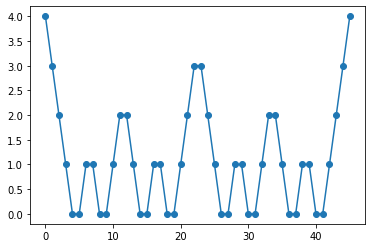

In [135]:
plt.plot(M.levels, '-o')

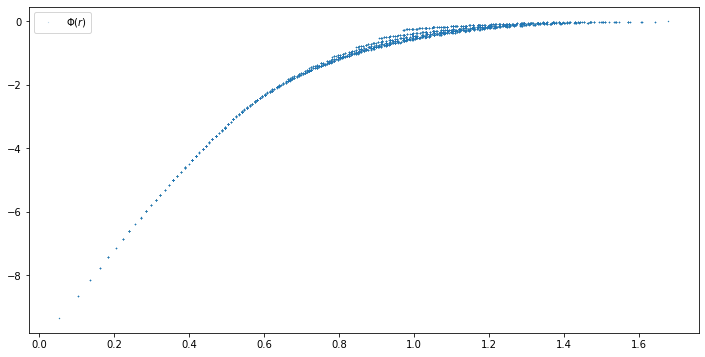

In [136]:
f = plt.figure(figsize=(12,6))
plt.plot(u.r.ravel(),Phi.ravel(),'o',markersize=0.1,label=r'$\Phi(r)$')
plt.legend();

I want to comment on the residuals to finish this off.

Note that the residuals are skewing a bit to the side, they aren't spherically symmetrical, nor isotropic nor anything. This is because we shift the entire grid every time we go from coarse to fine grid. I have tried to work around this by shifting things different ways, starting at either 0, or 1 before taking out every second point. However this doesn't get rid of the problem, but does improve the cpnvergence by a couple of iterations. It's not really important but still curious.

If you run an F or V-cycle for high tolerance, the residuals become very "gridded", so we see the flaw in our method here

MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
Nr of iterations, error, tolerance : 909 9.92e-11 1.0e-10
Time = 6.3 seconds, 191.3 musec/cell, 210.4 nanosec/cell/it


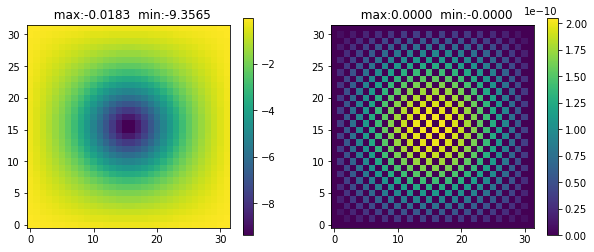

In [144]:
n=32
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = Multigrid(u,maxit=8000,itsmooth=1,tolerance=1e-10, solvetype='V')   # Setup the Multigrid solver object

start = time()              # for timing
Phi, res = M.solve(u)       # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*M.it)))

# show potential and residual
im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

But the solution is still beautiful and correct